In [1]:
import pyNUISANCE as pn
rf = pn.RecordFactory()
hepdata_rec = rf.make_record({"type":"hepdata", "recordpath":"/root/software/NUISANCEMC/neutrino_data/data/T2K/CrossSection/CC0Pi_CO_TKI_2024/submission-999999"})

Welcome to JupyROOT 6.30/04


In [2]:
ana = hepdata_rec.analysis("cross_section_c")
probe_flux_count = ana.get_probe_flux(False)
probe_flux_count_density = ana.get_probe_flux(True)

pn.convert.ROOT.write_TH1("flux_for_t2k_CC0Pi_CO_TKI.root",
                          "flux_count", probe_flux_count.spectrum,False,"RECREATE")
pn.convert.ROOT.write_TH1("flux_for_t2k_CC0Pi_CO_TKI.root",
                          "flux_count_density", probe_flux_count_density.spectrum,False,"UPDATE")

print(probe_flux_count.probe_pdg)
print(probe_flux_count.source)
[ str(tgt) for tgt in ana.get_target() ]

14
/root/software/NUISANCEMC/eventinput/data/hepdata-sandbox/1722947187/HEPData-1722947187-v1/t2kflux_2020_minus250ka_nd280_runcond.yaml


['1000060120']

In [3]:
%%bash
# only generate if we haven't already
if [ ! -e events_for_t2k_CC0Pi_CO_TKI.C.root ]; then
    neut-quickstart -t C -s numu \
                -f flux_for_t2k_CC0Pi_CO_TKI.root,flux_count \
                -n 500000 --neut-param "NEUT-MDLQE" 402\
                --neut-param NEUT-MAQE 1.21 \
                --neut-param NEUT-SFCORRNNFRAC 0.33 \
                --output-card t2k_CC0Pi_CO_TKI.C.card \
                -o events_for_t2k_CC0Pi_CO_TKI.C.root &
fi
if [ ! -e events_for_t2k_CC0Pi_CO_TKI.O.root ]; then
    neut-quickstart -t O -s numu \
                -f flux_for_t2k_CC0Pi_CO_TKI.root,flux_count \
                -n 500000 --neut-param "NEUT-MDLQE" 402\
                --neut-param NEUT-MAQE 1.21 \
                --neut-param NEUT-SFCORRNNFRAC 0.33 \
                --output-card t2k_CC0Pi_CO_TKI.O.card \
                -o events_for_t2k_CC0Pi_CO_TKI.O.root &
fi
wait

In [4]:
neut_events_C = pn.EventSource("events_for_t2k_CC0Pi_CO_TKI.C.root")
if not neut_events_C:
    print("Failed to read file")

neut_events_O = pn.EventSource("events_for_t2k_CC0Pi_CO_TKI.O.root")
if not neut_events_O:
    print("Failed to read file")

nuwro_events_C = pn.EventSource("events_for_t2k_CC0Pi_CO_TKI.C.nuwro.root")
if not nuwro_events_C:
    print("Failed to read file")

nuwro_events_O = pn.EventSource("events_for_t2k_CC0Pi_CO_TKI.O.nuwro.root")
if not nuwro_events_O:
    print("Failed to read file")

In [5]:
ana = hepdata_rec.analysis("cross_section_co")
comparison_CO_neut = ana.process([neut_events_C, neut_events_O])
comparison_CO_nuwro = ana.process([nuwro_events_C, nuwro_events_O])

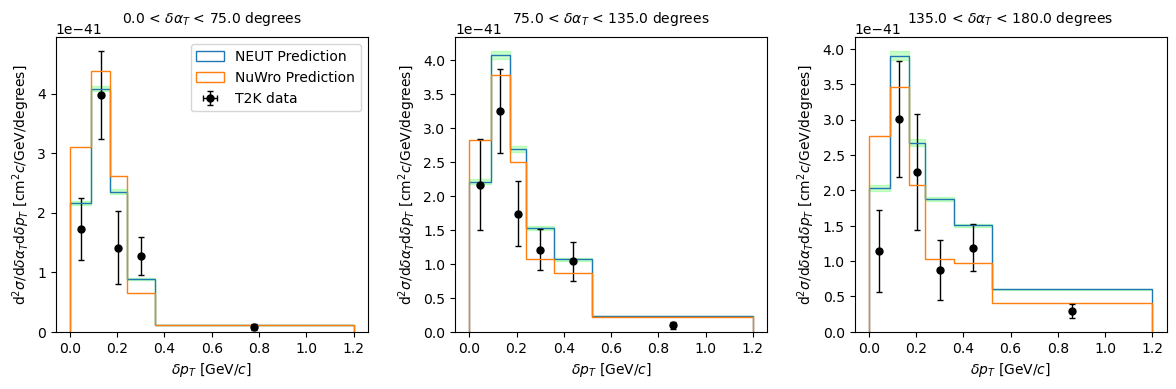

In [6]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,3, figsize=(12,4))

d_x_bin_centers = pn.Binning.get_bin_centers1D(comparison_CO_neut.data[0].project(0).binning.bins)
d_x_bin_edges = pn.Binning.get_bin_edges1D(comparison_CO_neut.data[0].project(0).binning.bins)

for i in range(len(d_x_bin_centers)):
    d_slice = comparison_CO_neut.data[0].slice(0,d_x_bin_centers[i])
    p_slice = comparison_CO_neut.predictions[0].slice(0,d_x_bin_centers[i])
    p_slice_nuwro = comparison_CO_nuwro.predictions[0].slice(0,d_x_bin_centers[i])
    
    d_slice.mpl().data_hist(plot_axis=axes[i], label="T2K data")
    p_slice.mpl().hist(histtype="step", plot_axis=axes[i], errorband_color="#0F03", label="NEUT Prediction")
    p_slice_nuwro.mpl().hist(histtype="step", plot_axis=axes[i], label="NuWro Prediction")

    x_proj_prettyname = ana.get_projections()[0].prettyname
    x_proj_unit = ana.get_projections()[0].units
    
    axes[i].text(0.5,1.05,f"{d_x_bin_edges[i]} < {x_proj_prettyname} < {d_x_bin_edges[i+1]} {x_proj_unit}",
                horizontalalignment="center",transform = axes[i].transAxes)
    
    if not i:
        axes[i].legend()

fig.tight_layout()
fig.show()

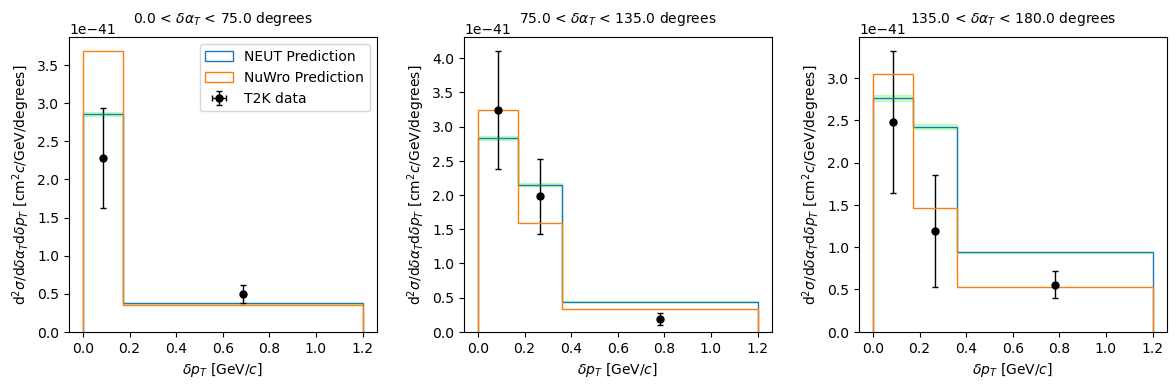

In [7]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,3, figsize=(12,4))

d_x_bin_centers = pn.Binning.get_bin_centers1D(comparison_CO_neut.data[1].project(0).binning.bins)
d_x_bin_edges = pn.Binning.get_bin_edges1D(comparison_CO_neut.data[1].project(0).binning.bins)

for i in range(len(d_x_bin_centers)):
    d_slice = comparison_CO_neut.data[1].slice(0,d_x_bin_centers[i])
    p_slice = comparison_CO_neut.predictions[1].slice(0,d_x_bin_centers[i])
    p_slice_nuwro = comparison_CO_nuwro.predictions[1].slice(0,d_x_bin_centers[i])

    d_slice.mpl().data_hist(plot_axis=axes[i], label="T2K data")
    p_slice.mpl().hist(histtype="step", errorband_color="#0F03", plot_axis=axes[i], label="NEUT Prediction")
    p_slice_nuwro.mpl().hist(histtype="step", plot_axis=axes[i], label="NuWro Prediction")

    x_proj_prettyname = ana.get_projections()[0].prettyname
    x_proj_unit = ana.get_projections()[0].units
    
    axes[i].text(0.5,1.05,f"{d_x_bin_edges[i]} < {x_proj_prettyname} < {d_x_bin_edges[i+1]} {x_proj_unit}",
                horizontalalignment="center",transform = axes[i].transAxes)
    
    if not i:
        axes[i].legend()

fig.tight_layout()
fig.show()

In [8]:
comparison_CO_neut.likelihood()

87.86557462282246

In [9]:
comparison_CO_nuwro.likelihood()

107.21967355572401

## Manual Mode

In [10]:
wf = pn.WeightCalcFactory()
neut_rw_C = wf.make(neut_events_C, {"plugin_name":"T2KReWeight", 
                      "neut_cardname": "t2k_CC0Pi_CO_TKI.C.card"})
neut_rw_O = wf.make(neut_events_O, {"plugin_name":"T2KReWeight", 
                      "neut_cardname": "t2k_CC0Pi_CO_TKI.O.card"})

 did scope guard 
 CRSPATH_ENV: /opt/neut/5.8.0/share/neut/crsdat
 Reading t2k_CC0Pi_CO_TKI.C.card as card
 ======= CONFIGURATION FOR INTERACTIONS =======
 Reading t2k_CC0Pi_CO_TKI.C.card as a card file
 Using Spectral Function for elastic events
 NECARD : INPUTTED PARAMETER 
 NECARD : CRSPATH= /opt/neut/5.8.0/share/neut/crsdat/
 NECARD : FERM   =            0
 NECARD : PAUL   =            0
 NECARD : PAUL2p2h =            0
 NECARD : NEFF   =            0
 NECARD : NUCDEXITE =            1
 NECARD : MODL   =            1
 NECARD : MODH   =            1
 NECARD : KINH   =            1
 NECARD : MODE   =            0
 NECARD : COHEPI =            2
 NECARD : DIFPI  =            0
 ********* CCQE SETTINGS ***************
 NECARD : MDLQE   =          402
 NECARD : MDLQEAF =            1
 NECARD : MDL2P2H =            2
 NECARD : NV2P2HQVAL =            1
 NECARD : MAQE    =    1.21000004    
 NECARD : AXFFALPHA =  0.230000004    
 NECARD : AXFFBETA=   1.22000003    
 NECARD : AXFFGAMMA=  

In [11]:
# you can enable these if you want to convince yourself that weights do something
# neut_rw_C.set_parameters({"SRCFrac_C": 0.66, "MaCCQE": 1})
# neut_rw_O.set_parameters({"SRCFrac_O": 0.66, "MaCCQE": 1})

neut_rw_C.set_parameters({"CVSpread_NEUT": 1})
neut_rw_O.set_parameters({"SRCFrac_O": 0.66})

In [12]:
neut_evframe_C = pn.EventFrameGen(neut_events_C)
ana.add_to_framegen(neut_evframe_C)
neut_evframe_C.add_column("SF_SRC_Norm_C +1", neut_rw_C.calc_weight)

neut_evframe_O = pn.EventFrameGen(neut_events_O)
ana.add_to_framegen(neut_evframe_O)
neut_evframe_O.add_column("SF_SRC_Norm_O +1", neut_rw_O.calc_weight)

In [13]:
ef_c = neut_evframe_C.firstArrow(int(1E6))
ef_o = neut_evframe_O.firstArrow(int(1E6))

In [14]:
ef_o.to_pandas()

,event.number,weight.cv,fatx_per_sumw.pb_per_target.estimate,fatx_per_sumw.pb_per_nucleon.estimate,process.id,T2K_CC0Pi_CO_TKI_nu_2024_Select_C,T2K_CC0Pi_CO_TKI_nu_2024_Select_O,T2K_CC0Pi_CO_TKI_nu_2024_Project_DeltaAlphaT_deg,T2K_CC0Pi_CO_TKI_nu_2024_Project_DeltaPT_GeV_c,SF_SRC_Norm_O +1
0,0,1.0,2.610343e-01,1.631464e-02,200,0,1,6.341088e+01,1.011524e-01,1.000000
1,1,1.0,1.305171e-01,8.157322e-03,500,0,0,1.531861e+02,3.247928e-01,1.000000
2,2,1.0,8.701143e-02,5.438214e-03,600,0,0,1.636985e+02,2.772358e-01,1.000000
3,3,1.0,6.525857e-02,4.078661e-03,200,0,1,1.912310e+01,1.206792e-01,1.000000
4,4,1.0,5.220686e-02,3.262929e-03,200,0,0,1.784392e+02,1.377831e+00,0.507463
...,...,...,...,...,...,...,...,...,...,...
499995,499995,1.0,5.220728e-07,3.262955e-08,451,0,0,3.735929e+09,3.735929e+09,1.000000
499996,499996,1.0,5.220717e-07,3.262948e-08,400,0,0,1.733416e+02,2.425877e-01,1.000000
499997,499997,1.0,5.220707e-07,3.262942e-08,400,0,0,9.667084e+01,3.218578e-02,1.000000
499998,499998,1.0,5.220696e-07,3.262935e-08,200,0,1,4.664992e+00,2.433813e-01,1.000000


In [15]:
# I know this is hideous, its what the ana.process function does internally, 
# but because we have no way, currently, of asking process to include more weights, 
# we have to do it all manually here

mc_c_srcp1 = comparison_CO_neut.data[0].make_HistFrame()
proj_names_c = [ x.fname for x in ana.get_all_projections()[0] ]
sel_name_c = ana.get_all_selection()[0].fname
print(f"Projections: {proj_names_c}\nSelections:{sel_name_c}")


mc_c_srcp1.fill(ef_c,  proj_names_c, 
                [ pn.HistFrame.fill_column(0),
                  pn.HistFrame.fill_if(sel_name_c),
                  pn.HistFrame.weight_by("SF_SRC_Norm_C +1") ])


xs_scaling_c = ana.get_all_cross_section_scalings()[0]
pred_c_srcp1 = mc_c_srcp1.finalise(xs_scaling_c.divide_by_bin_width)\
                .scale( neut_events_C.norm_info(xs_scaling_c.units).fatx_per_sumweights() 
                           * xs_scaling_c.extra_scale_factor)

mc_o_srcp1 = comparison_CO_neut.data[1].make_HistFrame()
proj_names_o = [ x.fname for x in ana.get_all_projections()[0] ]
sel_name_o = ana.get_all_selection()[1].fname
print(f"Projections: {proj_names_o}\nSelections:{sel_name_o}")
mc_o_srcp1.fill(ef_o,  proj_names_o, 
                [ pn.HistFrame.fill_column(0),
                  pn.HistFrame.fill_if(sel_name_o),
                  pn.HistFrame.weight_by("SF_SRC_Norm_O +1") ])
xs_scaling_o = ana.get_all_cross_section_scalings()[1]
pred_o_srcp1 = mc_o_srcp1.finalise(xs_scaling_o.divide_by_bin_width)\
                .scale( neut_events_C.norm_info(xs_scaling_o.units).fatx_per_sumweights() 
                           * xs_scaling_o.extra_scale_factor)


Projections: ['T2K_CC0Pi_CO_TKI_nu_2024_Project_DeltaAlphaT_deg', 'T2K_CC0Pi_CO_TKI_nu_2024_Project_DeltaPT_GeV_c']
Selections:T2K_CC0Pi_CO_TKI_nu_2024_Select_C
Projections: ['T2K_CC0Pi_CO_TKI_nu_2024_Project_DeltaAlphaT_deg', 'T2K_CC0Pi_CO_TKI_nu_2024_Project_DeltaPT_GeV_c']
Selections:T2K_CC0Pi_CO_TKI_nu_2024_Select_O


# Doing things manually

erjgjoerjgioergj

```some code example```

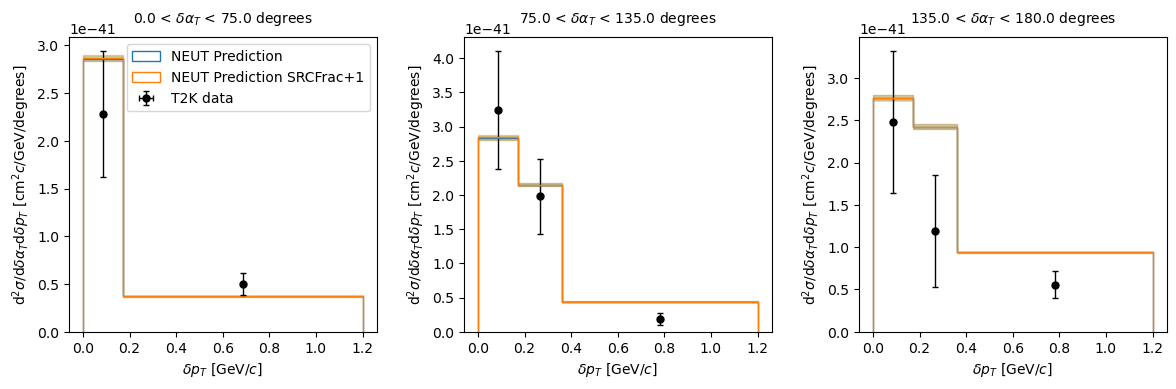

In [16]:
fig, axes = plt.subplots(1,3, figsize=(12,4))

d_x_bin_centers = pn.Binning.get_bin_centers1D(comparison_CO_neut.data[1].project(0).binning.bins)
d_x_bin_edges = pn.Binning.get_bin_edges1D(comparison_CO_neut.data[1].project(0).binning.bins)

for i in range(len(d_x_bin_centers)):
    d_slice = comparison_CO_neut.data[1].slice(0,d_x_bin_centers[i])
    p_slice = comparison_CO_neut.predictions[1].slice(0,d_x_bin_centers[i])
    p_slice_w = pred_o_srcp1.slice(0,d_x_bin_centers[i])
    # p_slice_nuwro = comparison_CO_nuwro.predictions[1].slice(0,d_x_bin_centers[i])

    d_slice.mpl().data_hist(plot_axis=axes[i], label="T2K data")
    p_slice.mpl().hist(histtype="step", errorband_color="#0F03", plot_axis=axes[i], label="NEUT Prediction")
    p_slice_w.mpl().hist(histtype="step", errorband_color="#F003", plot_axis=axes[i], label="NEUT Prediction SRCFrac+1")
    # p_slice_nuwro.mpl().hist(histtype="step", plot_axis=axes[i], label="NuWro Prediction")

    x_proj_prettyname = ana.get_projections()[0].prettyname
    x_proj_unit = ana.get_projections()[0].units
    
    axes[i].text(0.5,1.05,f"{d_x_bin_edges[i]} < {x_proj_prettyname} < {d_x_bin_edges[i+1]} {x_proj_unit}",
                horizontalalignment="center",transform = axes[i].transAxes)
    
    if not i:
        axes[i].legend()

fig.tight_layout()
fig.show()